In [ ]:
# Installing the requried Libraries
!pip install requests
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

In [2]:
# Read the NIST Filip source data, and process the data
import requests
import pandas as pd
response = requests.get("https://www.itl.nist.gov/div898/strd/lls/data/LINKS/DATA/Filip.dat")
if response.status_code!=200:
    raise ConnectionError("Could not fetch the source data")
data_str = response.content.decode("ascii")
print("RAW DATA FILE :\n-----------------------------------\n", data_str[:300])
X = []
y = []
print("\n### PROCESSED DATA\n--------------------------------\ny\t\tx",)
for row in data_str.splitlines()[60:]:
    yi, xi = [float(cell) for cell in row.strip(" ").split(" ") if cell]
    X.append(xi)
    y.append(yi)
for xi,yi in zip(X[:5], y[:5]):
    print(f"{yi}\t{xi}")
else:
    for _ in range(3):
        print("...\t...")
    print(f"{y[-1]}\t{X[-1]}")
    print(f"[Data Shape: {len(X)}x2]") 
# df=pd.DataFrame([[cell for cell in row.strip(" ").split(" ") if cell] for row in data_str.splitlines()[60:]], 
#                 columns=["y", "x"], 
#                 dtype="float")

RAW DATA FILE :
-----------------------------------
 NIST/ITL StRD
Dataset Name:  Filip (Filip.dat)

File Format:   ASCII
               Certified Values  (lines 31 to 55)
               Data              (lines 61 to 142)

Procedure:     Linear Least Squares Regression

Reference:     Filippelli, A., NIST.

Data:          1 Response Variab

### PROCESSED DATA
--------------------------------
y		x
0.8116	-6.860120914
0.9072	-4.324130045
0.9052	-4.358625055
0.9039	-4.358426747
0.8053	-6.955852379
...	...
...	...
...	...
0.9228	-3.2644011
[Data Shape: 82x2]


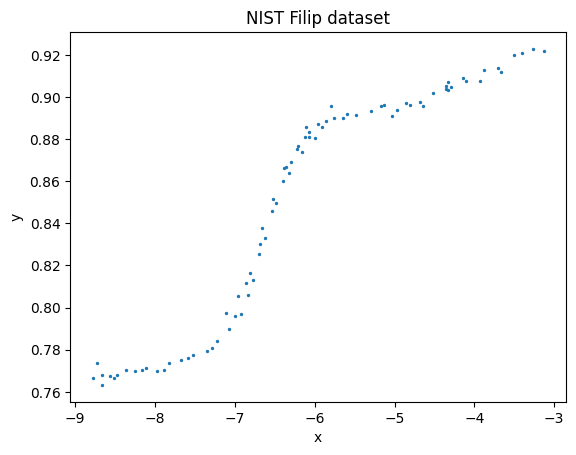

In [3]:
# Visualizing the data samples
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(X, y, s=2)
ax.set_xlabel("x")
ax.set_ylabel("y")
_=ax.set_title("NIST Filip dataset")

# from sklearn.linear_model import LinearRegression
# model = LinearRegression().fit(np.reshape(X, (-1,1)), y)
# x_plot = np.linspace(min(X), max(X), 100)
# y_pred = model.predict(np.reshape(x_plot, (-1,1)))
# ax.plot(x_plot, y_pred, color="red", label="Simplest Regression", linewidth=1)

Training score (R-squarred):  0.9965535591903646
Learned parameters (b0 to b10):
 [-1.46748854e+03 -2.77218006e+03 -2.31637155e+03 -1.12797412e+03
 -3.54478274e+02 -7.51242076e+01 -1.08753187e+01 -1.06221504e+00
 -6.70191183e-02 -2.46781088e-03 -4.02962543e-05]


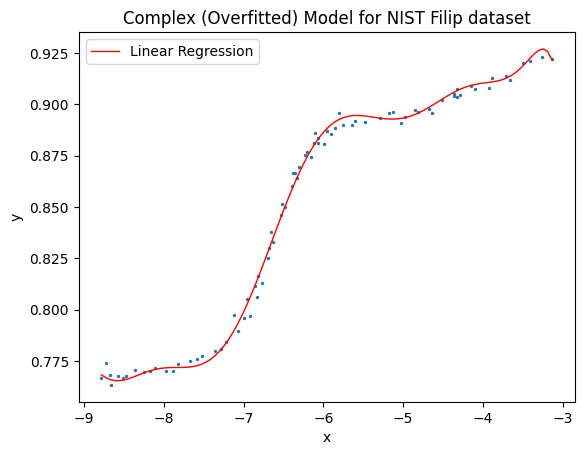

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np
# Create higher order term features from the given feature
X_new = [[x**i for i in range(1, 11)] for x in X]
linear_model = LinearRegression().fit(X_new, y)
parameters = np.hstack([linear_model.intercept_, linear_model.coef_])
print("Training score (R-squarred): ", linear_model.score(X_new, y))
print("Learned parameters (b0 to b10):\n", parameters)

# Plot the regression
X_plot = [[x**i for i in range(1, 11)] for x in np.linspace(min(X), max(X), 100)]
y_pred = linear_model.predict(X_plot)
# print(y_pred)
ax.plot([x[0] for x in X_plot], y_pred, color="red", label="Linear Regression", linewidth=1)
ax.legend()
ax.set_title("Complex (Overfitted) Model for NIST Filip dataset")
fig

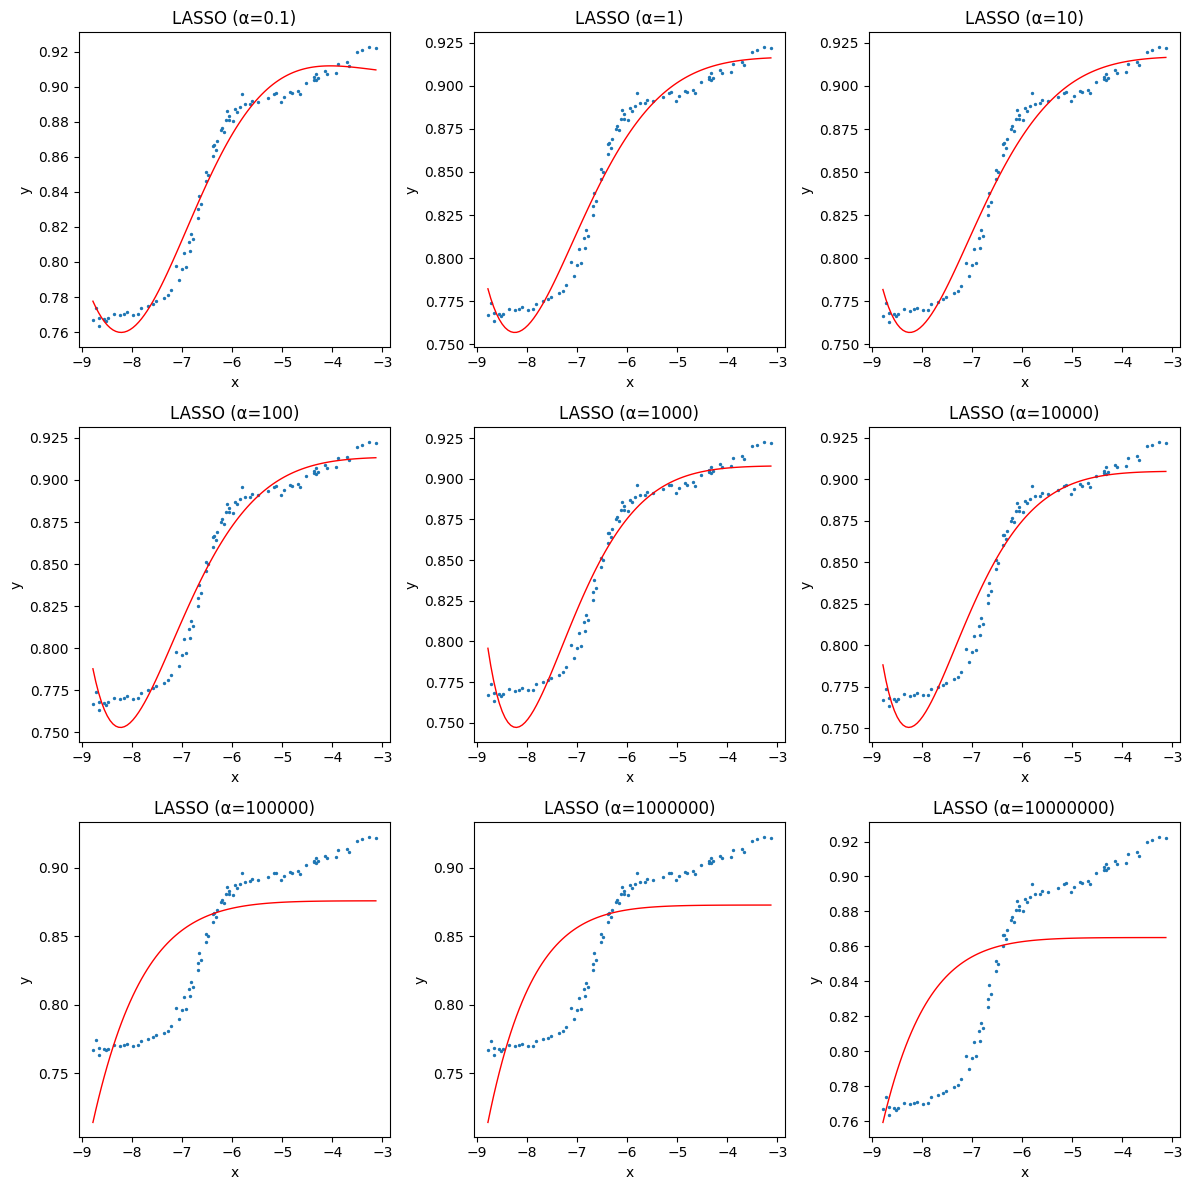

In [5]:
from sklearn.linear_model import Lasso
import warnings

alpha = 0.1
fig, axes = plt.subplots(3, 3, figsize=(12,12))
parameters = {}
for i in range(9):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = Lasso(alpha=alpha, max_iter=1000000).fit(X_new, y)
    parameters[alpha]=[float(p) for p in np.hstack([model.intercept_, model.coef_])]
    y_pred = model.predict(X_plot)
    axes[i//3, i%3].scatter(X, y, s=2)
    axes[i//3, i%3].plot([x[0] for x in X_plot], y_pred, color="red", linewidth=1)
    # axes[i//2, i%2].legend()
    axes[i//3, i%3].set_title(f"LASSO (α={alpha}".rstrip("0").rstrip(".") + ")")
    axes[i//3, i%3].set_xlabel("x")
    axes[i//3, i%3].set_ylabel("y")
    alpha *= 10
fig.tight_layout()

In [6]:
df=pd.DataFrame.from_dict(parameters)
df = (df
      .rename(columns=lambda x: f"α={x}".rstrip("0").rstrip("."))
      .assign(parameter=[f"b{i}" for i in range(11)])
      .set_index("parameter")
    )
df

,α=0.1,α=1,α=10,α=100,α=1000,α=10000,α=100000,α=1000000,α=10000000
parameter,,,,,,,,,
b0,9.059272e-01,9.168062e-01,9.171227e-01,9.136646e-01,9.079455e-01,9.049785e-01,8.758820e-01,8.728333e-01,8.650693e-01
b1,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
b2,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
b3,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
b4,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
b5,-2.698188e-05,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
b6,0.000000e+00,7.808570e-08,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
b7,2.172090e-06,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
b8,1.598366e-07,-1.238866e-07,-1.189010e-07,-7.195030e-08,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


## Conclusion
### Linear Regression with Higher Order Terms (Overfitting Model)
The first linear regression with higher terms clearly overfits as it tries to capture as much data points as possible, instead of learning the generalization from the data. Additionally, all the parameters from the model are significant which makes the model complex.
### Linear Regressions with penalization (Robust Model)
The 9 Lasso with 9 different **α** values ranging from *0.1 to 10000000* are shown in the above diagram. Unlike the linear regression, the first 6 regressions try to learn the general pattern in the data and have less number of significant/non-zero parameters. By visual inspection, the LASSO with **α** values 1 and 10 seem to form a robust model that captures the generalization from the data while keeping the model simpler--keeping 6 and 5 parameters respectively.
### Linear Regressions with penalization (Underfitting Model)
The last 3 models with much higher **α** values certainly fail to capture the trend in the data. These models are much simpler (from 3 to 2 parameters), and thus underfit.